In [1]:
from pystac_client import Client
from matplotlib.colors import ListedColormap
import rasterio
import rasterio.mask
import numpy as np
import pystac
import planetary_computer as pc

In [3]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [ 178.478431, -17.6426563 ], 
            [ 178.4875358, -17.6427653 ], 
            [ 178.5163223, -17.6076001 ], 
            [ 178.5020381, -17.6065642 ], 
            [ 178.478431, -17.6426563 ],
        ]
    ],
}

In [4]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
jrc = catalog.search(collections=["jrc-gsw"], intersects=area_of_interest)

items = list(jrc.get_items())

print(f"Returned {len(items)} Items")

Returned 1 Items


In [6]:
item = items[0]

In [7]:
cog_assets = [
    asset_key
    for asset_key, asset in item.assets.items()
    if asset.media_type == pystac.MediaType.COG
]

In [8]:
cmaps = {}
for asset_key in cog_assets:
    asset = item.assets[asset_key]
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        colormap_def = src.colormap(1)  # get metadata colormap for band 1
        colormap = [
            np.array(colormap_def[i]) / 256 for i in range(256)
        ]  # transform to matplotlib color format
    cmaps[asset_key] = ListedColormap(colormap)
    

In [9]:
# Downsample the scene for plotting
def read_asset_data(asset_key):
    with rasterio.open(pc.sign(item.assets[asset_key].href)) as src:
        out_image, _ = rasterio.mask.mask(
            src, [area_of_interest], crop=True, nodata=255
        )

    return out_image

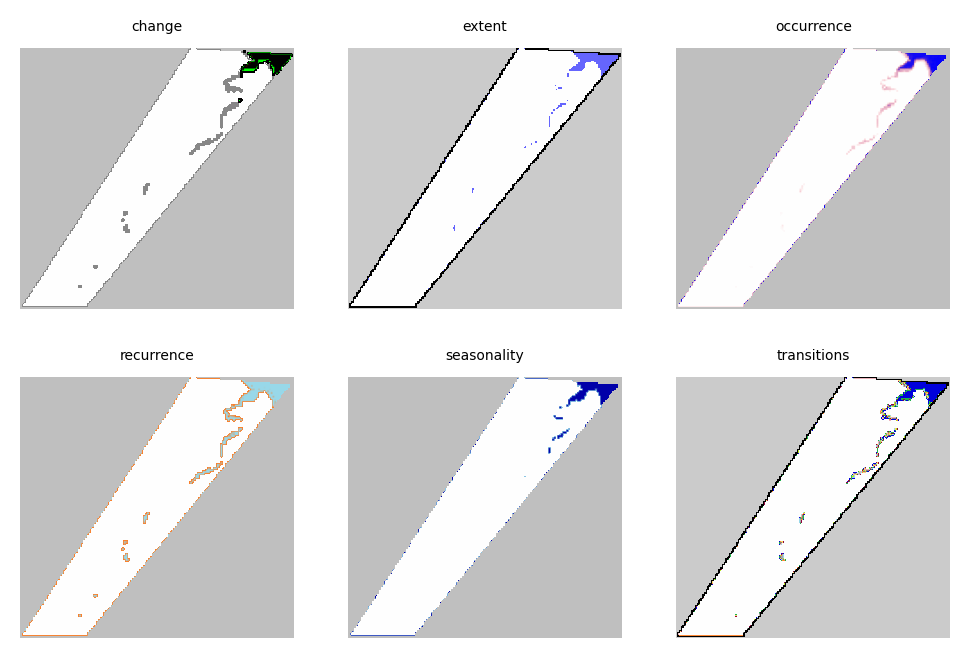

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

dpi = 200
fig = plt.figure(frameon=False, dpi=dpi)

for i, asset_key in enumerate(cog_assets):
    asset_data = read_asset_data(asset_key)
    ax1 = fig.add_subplot(int(f"23{i+1}"))
    ax1.set_title(asset_key, fontdict={"fontsize": 5})
    ax1.set_axis_off()
    plt.imshow(asset_data[0], norm=Normalize(0, 255), cmap=cmaps[asset_key])
    